In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader,TensorDataset,random_split,SubsetRandomSampler, ConcatDataset
from torch.nn import functional as F
import torchvision
from torchvision import datasets,transforms
import torchvision.transforms as transforms

train_dataset = torchvision.datasets.MNIST('classifier_data', train=True, download=True)
test_dataset  = torchvision.datasets.MNIST('classifier_data', train=False, download=True)

transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor()
])

train_dataset.transform=transform
test_dataset.transform=transform

m=len(train_dataset)

#random_split randomly split a dataset into non-overlapping new datasets of given lengths
train_data, val_data = random_split(train_dataset, [int(m-m*0.2), int(m*0.2)])

batch_size=128

# The dataloaders handle shuffling, batching, etc...
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size)
valid_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,shuffle=True)

print("Batches in Train Loader: {}".format(len(train_loader)))
print("Batches in Valid Loader: {}".format(len(valid_loader)))
print("Batches in Test Loader: {}".format(len(test_loader)))

print("Examples in Train Loader: {}".format(len(train_loader.sampler)))
print("Examples in Valid Loader: {}".format(len(valid_loader.sampler)))
print("Examples in Test Loader: {}".format(len(test_loader.sampler)))

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting classifier_data/MNIST/raw/train-images-idx3-ubyte.gz to classifier_data/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting classifier_data/MNIST/raw/train-labels-idx1-ubyte.gz to classifier_data/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting classifier_data/MNIST/raw/t10k-images-idx3-ubyte.gz to classifier_data/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting classifier_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to classifier_data/MNIST/raw

Batches in Train Loader: 375
Batches in Valid Loader: 94
Batches in Test Loader: 79
Examples in Train Loader: 48000
Examples in Valid Loader: 12000
Examples in Test Loader: 10000


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


## 1. Define CNN architecture

In [2]:
class ConvNet(nn.Module):
    def __init__(self,h1=96):
        # We optimize dropout rate in a convolutional neural network.
        super(ConvNet, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=5, stride=1, padding=2)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5, stride=1, padding=2)
        self.drop1=nn.Dropout2d(p=0.5)  
        
        self.fc1 = nn.Linear(32 * 7 * 7, h1)
        self.drop2=nn.Dropout2d(p=0.1)
        self.fc2 = nn.Linear(h1, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x),kernel_size = 2))
        x = F.relu(F.max_pool2d(self.conv2(x),kernel_size = 2))
        x = self.drop1(x)

        x = x.view(x.size(0),-1)

        x = F.relu(self.fc1(x))
        x = self.drop2(x)
        return self.fc2(x)

## 2. Initialize

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
torch.manual_seed(0)
model = ConvNet()
model.to(device)
optimizer = optim.Adam(model.parameters(), lr=0.002)
criterion= nn.CrossEntropyLoss()

## 3. Training

In [4]:
history={'train_loss':[],'valid_loss':[],'train_acc':[],'valid_acc':[]}
num_epochs=10

for epoch in range(num_epochs):
    train_loss,train_correct=0.0,0
    model.train()
    for images, labels in train_loader:

        images,labels = images.to(device),labels.to(device)
        optimizer.zero_grad()
        output = model(images)
        loss = criterion(output,labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * images.size(0)
        scores, predictions = torch.max(output.data, 1)
        train_correct += (predictions == labels).sum().item()    
    
    valid_loss, val_correct = 0.0, 0
    model.eval()
    for images, labels in valid_loader:

        images,labels = images.to(device),labels.to(device)
        output = model(images)
        loss=criterion(output,labels)
        valid_loss+=loss.item()*images.size(0)
        scores, predictions = torch.max(output.data,1)
        val_correct+=(predictions == labels).sum().item()

    train_loss = train_loss / len(train_loader.sampler)
    train_acc = train_correct / len(train_loader.sampler)*100
    valid_loss = valid_loss / len(valid_loader.sampler)
    valid_acc = val_correct / len(valid_loader.sampler) * 100

    print("Epoch:{}/{} \t AVERAGE TL:{:.4f} AVERAGE VL:{:.4f} \t AVERAGE TA:{:.2f} %  AVERAGE VA:{:.2f} %".format(epoch + 1, num_epochs,
                                                                                         train_loss,
                                                                                         valid_loss,
                                                                                         train_acc,
                                                                                        valid_acc))
    history['train_loss'].append(train_loss)    
    history['valid_loss'].append(valid_loss)  
    history['train_acc'].append(train_acc)  
    history['valid_acc'].append(valid_acc)  

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Epoch:1/10 	 AVERAGE TL:0.2815 AVERAGE VL:0.0729 	 AVERAGE TA:91.30 %  AVERAGE VA:97.81 %
Epoch:2/10 	 AVERAGE TL:0.0914 AVERAGE VL:0.0495 	 AVERAGE TA:97.27 %  AVERAGE VA:98.43 %
Epoch:3/10 	 AVERAGE TL:0.0671 AVERAGE VL:0.0409 	 AVERAGE TA:97.90 %  AVERAGE VA:98.76 %
Epoch:4/10 	 AVERAGE TL:0.0555 AVERAGE VL:0.0352 	 AVERAGE TA:98.35 %  AVERAGE VA:98.94 %
Epoch:5/10 	 AVERAGE TL:0.0508 AVERAGE VL:0.0363 	 AVERAGE TA:98.39 %  AVERAGE VA:98.88 %
Epoch:6/10 	 AVERAGE TL:0.0421 AVERAGE VL:0.0325 	 AVERAGE TA:98.70 %  AVERAGE VA:99.03 %
Epoch:7/10 	 AVERAGE TL:0.0366 AVERAGE VL:0.0390 	 AVERAGE TA:98.84 %  AVERAGE VA:98.94 %
Epoch:8/10 	 AVERAGE TL:0.0347 AVERAGE VL:0.0331 	 AVERAGE TA:98.89 %  AVERAGE VA:99.08 %
Epoch:9/10 	 AVERAGE TL:0.0322 AVERAGE VL:0.0325 	 AVERAGE TA:98.98 %  AVERAGE VA:99.04 %
Epoch:10/10 	 AVERAGE TL:0.0354 AVERAGE VL:0.0342 	 AVERAGE TA:98.89 %  AVERAGE VA:99.12 %


## 4. Evaluation

In [5]:
correct = 0
total = 0
test_loss = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs,labels)
        test_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

test_loss = test_loss / len(test_loader.sampler)

print('Accuracy of the network on the test images: {:.2f} %%'.format(100 * correct / total))
print('Loss of the network on the test images: {:.4f}'.format(test_loss))

Accuracy of the network on the test images: 99.04 %%
Loss of the network on the test images: 0.0281


## 5. Visualize Filters

In [6]:
model_weights = [] 
conv_layers = [] 
model_children = list(model.children())

# counter to keep count of the conv layers
counter = 0 
# append all the conv layers and their respective weights to the list
for i in range(len(model_children)):
    if type(model_children[i]) == nn.Conv2d:
        counter += 1
        model_weights.append(model_children[i].weight)
        conv_layers.append(model_children[i])
    elif type(model_children[i]) == nn.Sequential:
        for j in range(len(model_children[i])):
            for child in model_children[i][j].children():
                if type(child) == nn.Conv2d:
                    counter += 1
                    model_weights.append(child.weight)
                    conv_layers.append(child)
print(f"Total convolutional layers: {counter}")

Total convolutional layers: 2


In [7]:
for weight, conv in zip(model_weights, conv_layers):
    # print(f"WEIGHT: {weight} \nSHAPE: {weight.shape}")
    print(f"CONV: {conv} ====> SHAPE: {weight.shape}")

CONV: Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2)) ====> SHAPE: torch.Size([16, 1, 5, 5])
CONV: Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2)) ====> SHAPE: torch.Size([32, 16, 5, 5])


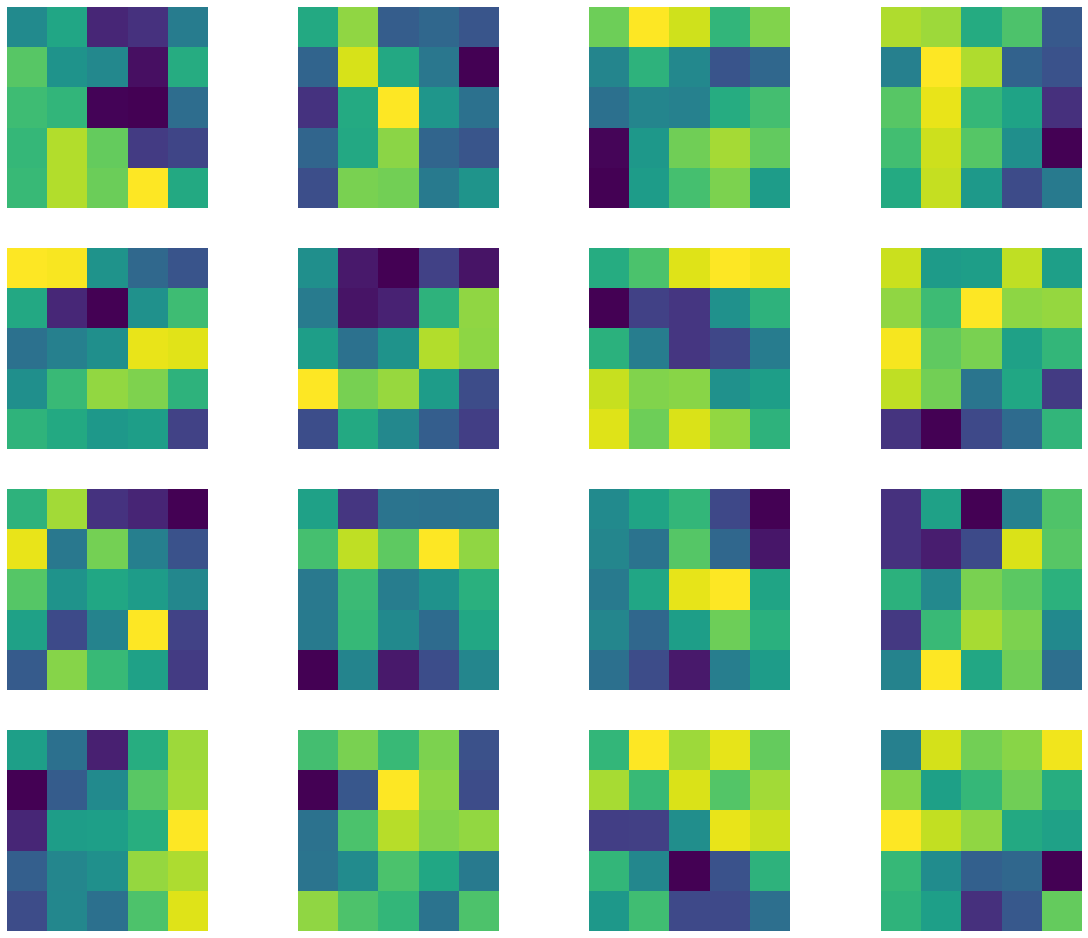

In [8]:
# visualize the first conv layer filters
plt.figure(figsize=(20, 17))
for i, filter in enumerate(model_weights[0]):
    plt.subplot(4, 4, i+1) # we have 5x5 filters and total of 16 (see printed shapes)
    plt.imshow(filter[0, :, :].detach().cpu().numpy(), cmap='viridis')
    plt.axis('off')
    plt.savefig('filter1.png')
plt.show()

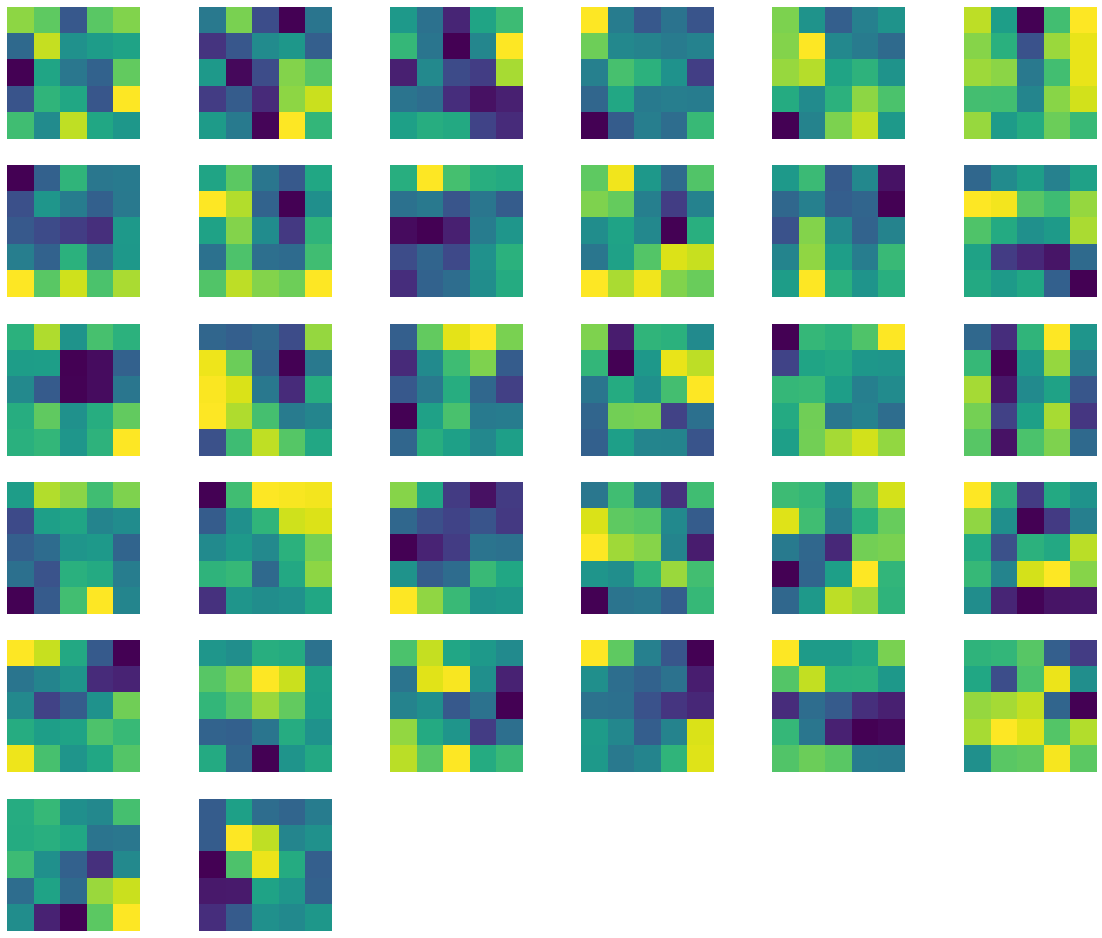

In [9]:
# visualize the second conv layer filters
plt.figure(figsize=(20, 17))
for i, filter in enumerate(model_weights[1]):
    plt.subplot(6, 6, i+1) # (8, 8) because in conv0 we have 5x5 filters and total of 64 (see printed shapes)
    plt.imshow(filter[0, :, :].detach().cpu().numpy(), cmap='viridis')
    plt.axis('off')
    plt.savefig('filter2.png')
plt.show()

## 6. Visualize Feature Maps

In [10]:
activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

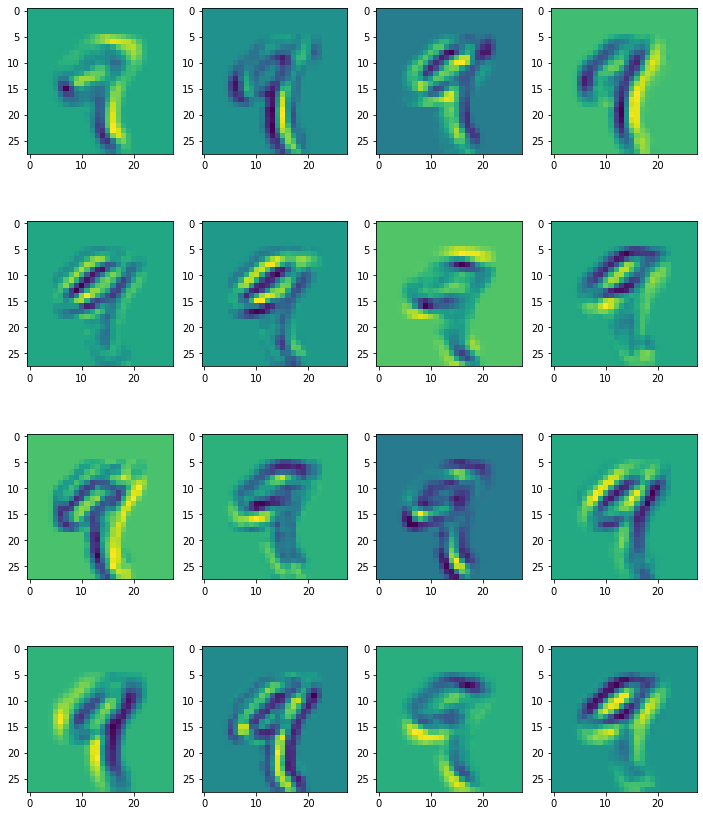

In [11]:
model.conv1.register_forward_hook(get_activation('conv1'))
data, _ = train_dataset[4]
data=data.to(device)
data.unsqueeze_(0)
output = model(data)

k=0
act = activation['conv1'].squeeze()
fig,ax = plt.subplots(4,4,figsize=(12, 15))

for i in range(act.size(0)//4):
        for j in range(act.size(0)//4):
           ax[i,j].imshow(act[k].detach().cpu().numpy())
           k+=1    
           plt.savefig('fm1.png') 

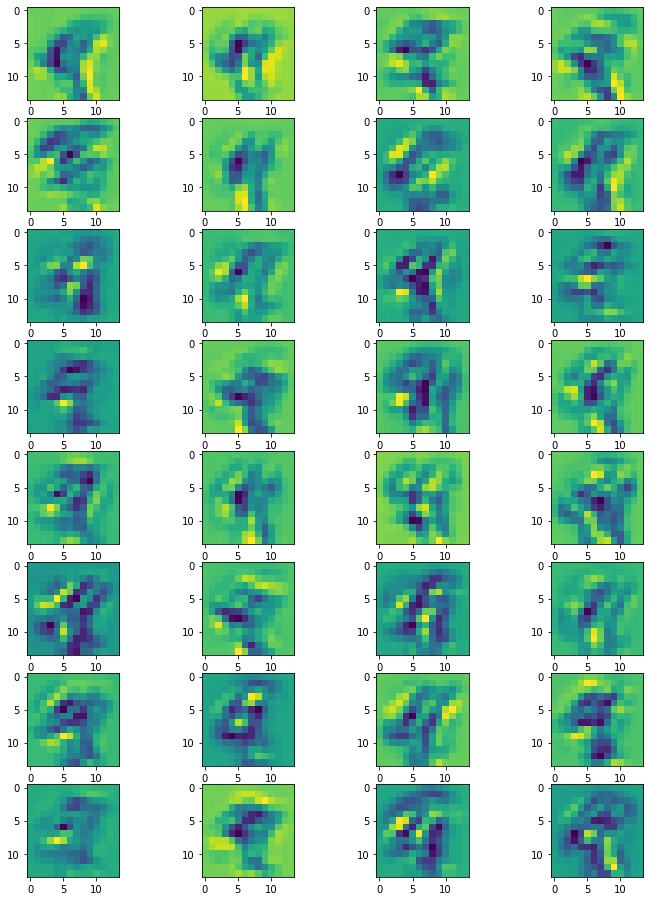

In [12]:
model.conv2.register_forward_hook(get_activation('conv2'))
data, _ = train_dataset[4]
data=data.to(device)
data.unsqueeze_(0)
output = model(data)
act = activation['conv2'].squeeze()

fig, axarr = plt.subplots(act.size(0)//4,4,figsize=(12, 16))
k=0
for i in range(act.size(0)//4):
        for j in range(4):
          axarr[i,j].imshow(act[k].detach().cpu().numpy())
          k+=1  
          plt.savefig('fm2.png')  